# Custom DataLoader with Rick and Morty API

## Intro 

**Overview**

This notebook is designed as an experimental playground to explore and exercise various concepts related to data loading, neural network implementation, and image classification. The focus is on building a custom DataLoader by leveraging the Rick and Morty API to fetch and preprocess data, which will then be used to train convolutional neural networks (CNNs).

**Goals**

- **Develop a Custom DataLoader**: Construct a DataLoader from scratch that interfaces with the Rick and Morty API, allowing us to dynamically fetch and preprocess image data directly from the API.
- **Implement a Custom CNN**: Design and train a custom CNN to classify images of characters from the Rick and Morty series, enabling us to experiment with different architectural decisions.
- **Utilize Pretrained Models**: Compare the performance of our custom CNN with that of a pretrained model, understanding the advantages and limitations of using transfer learning in this context.
- **Experimentation**: Use this setup as a sandbox to test various hypotheses about data preprocessing, network architecture, and training strategies.

**Dataset**

The dataset will be dynamically generated using the [Rick and Morty API](https://rickandmortyapi.com/), which provides access to numerous images and data points about characters from the popular show "Rick and Morty". Each API call retrieves different character data, which we will preprocess and use as input for our neural networks.

**Neural Networks**

1. **Custom CNN**: A convolutional neural network designed from scratch to fit our specific dataset. This will allow us to explore the intricacies of CNN design and training.
2. **Pretrained Model**: Utilization of a pretrained network to investigate the benefits of transfer learning on a relatively small and specific dataset like ours.

**Tools and Libraries**

- **PyTorch**: For implementing and training the neural networks.
- **Pandas**: For data manipulation and analysis.
- **Matplotlib** and **Seaborn**: For visualizing data and training results.

**Objective**

The primary objective of this notebook is to gain hands-on experience with practical aspects of machine learning, from data gathering and preprocessing to model training and evaluation. This experiment will help understand how different techniques and approaches impact the performance of deep learning models in real-world tasks.

**Disclaimer**

The text of this notebook was partially generated with AI to enhance clarity and communication.

In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

from torchinfo import summary


from rich_and_morty_dataset import RichAndMortyDataSet

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define the device
DEVICE = "cpu"  # default device is cpu

if torch.cuda.is_available():
    DEVICE = "cuda"  # if cuda is available, use it
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # if mps is available, use it

NUM_WORKERS = 6  # number of workers for data loader -> change this depending on the number of cores in your machine

IMG_WIDTH = 128
IMG_HEIGHT = 128

## Data Loading

The `RichAndMortyDataSet` class fetches and preprocesses image data from the Rick and Morty API. This dataset is designed to support dynamic data fetching and apply necessary transformations for training neural networks.

**Features**

- **Dynamic Fetching**: Retrieves character images and metadata from the Rick and Morty API.
- **Transformations**: Converts images to tensors and normalizes them.

In [4]:
rick_and_morty_ds = RichAndMortyDataSet(transform=None)

## Data Exploration

### Data Visualization

Let's start by visualizing some of the images and exploring the dataset's characteristics.

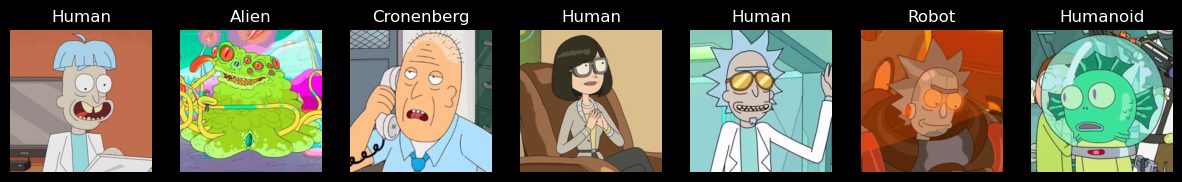

In [5]:
def show_image(ax, image, label):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(label)


def show_images(images, labels):
    fig, axes = plt.subplots(
        1, len(images), figsize=(15, 15)
    )  # Create a figure and a set of subplots
    if len(images) == 1:
        axes = [
            axes
        ]  # if there is only one image, then axes is not a list, so we make it a list
    for ax, image, label in zip(axes, images, labels):
        show_image(ax, image, label)
    plt.show()


def show_random_images(n_images=7):
    random_indices = np.random.choice(len(rick_and_morty_ds), n_images)
    images = [rick_and_morty_ds[i][0] for i in random_indices]
    labels = [
        rick_and_morty_ds.classes[rick_and_morty_ds[i][1].item()]
        for i in random_indices
    ]
    show_images(images, labels)


show_random_images(7)

### Data Analysis

In this section, we will perform an analysis of our dataset to understand its structure and characteristics. Specifically, we will examine:

- The total number of data points we have.
- The number of unique classes in the dataset.
- The distribution of these classes.
- Detailed information about the images, which are assumed to be all 250x250 pixels based on our data loading process.

In [6]:
data_len = len(rick_and_morty_ds)
class_len = len(rick_and_morty_ds.classes)

print(f"Data length: {data_len}")
print(f"Class length: {class_len}")

Data length: 826
Class length: 10


As we can see, this dataset is very small, with ~800 images distributed across 10 classes. This small size will pose a challenge for training deep learning models effectively, but it provides an excellent opportunity to experiment with different techniques and architectures. As result we decided to use **data augmentation** to increase the size of the dataset.

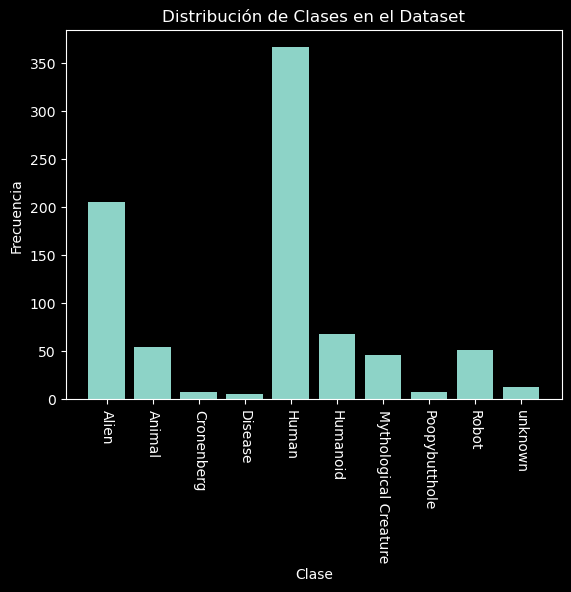

In [7]:
labels = [label.item() for _, label in rick_and_morty_ds]


# Contar la frecuencia de cada clase
unique_labels, counts = np.unique(labels, return_counts=True)
name_labels = [rick_and_morty_ds.classes[i] for i in unique_labels]

# Crear el histograma
plt.bar(name_labels, counts)
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases en el Dataset")
plt.xticks(
    name_labels
)  # Asegúrate de que todas las etiquetas de clase aparecen en el eje x
plt.xticks(rotation=270)  # O prueba con 90 para una rotación vertical completa

plt.show()

Clearly the dataset is imbalanced, with some classes having significantly more samples than others. This imbalance could potentially affect the performance of our models, especially for classes with fewer samples. We will need to consider strategies to address this issue during model training.
I decide to use weighted loss function to address this issue.

## Splitting the Dataset

In [8]:
train_transform = transforms.Compose(
    [
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Ensure all images are 128x128
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.RandomRotation(10),  # Randomly rotate images by +/- 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation and hue
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensors
    ]
)

# Validation and test transforms, no random augmentations
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

rick_and_morty_ds = RichAndMortyDataSet(transform=train_transform)

# Calculate the wieghts for each class
class_counts = torch.bincount(torch.tensor(labels))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalizar pesos
class_weights = class_weights.to(DEVICE)


# Define the sizes for each subset
train_size = int(0.7 * len(rick_and_morty_ds))
val_size = int(0.15 * len(rick_and_morty_ds))
test_size = len(rick_and_morty_ds) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(rick_and_morty_ds, [train_size, val_size, test_size])

# Update the transforms for validation and test sets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Custom CNN

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.img_height = img_height
        self.img_width = img_width

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Calculate the size of the input to the first fully connected layer
        self._to_linear = None
        self.convs(torch.randn(1, 3, self.img_height, self.img_width))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, self.num_classes)

    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
            print(f"Flattened size: {self._to_linear}")

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Flatten the output from conv layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


simple_cnn_model = SimpleCNN(
    num_classes=class_len, img_height=IMG_HEIGHT, img_width=IMG_WIDTH
).to(DEVICE)

summary(simple_cnn_model, input_size=(1, 3, IMG_HEIGHT, IMG_WIDTH))

Flattened size: 32768


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─MaxPool2d: 1-2                         [1, 32, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           18,496
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Conv2d: 1-5                            [1, 128, 32, 32]          73,856
├─MaxPool2d: 1-6                         [1, 128, 16, 16]          --
├─Linear: 1-7                            [1, 2048]                 67,110,912
├─Linear: 1-8                            [1, 512]                  1,049,088
├─Linear: 1-9                            [1, 10]                   5,130
Total params: 68,258,378
Trainable params: 68,258,378
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 234.23
Input size (MB): 0.20
Forward/backward pass size (MB): 7.36
Params size (MB): 

In [10]:
def train(
    model,
    train_dl,
    val_dl,
    optimizer,
    loss_fn,
    epochs=10,
    early_stopper=True,
    early_stopper_patience=5,
):
    best_val_loss = float("inf")
    patience = 0

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for _, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dl)

        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for _, (images, labels) in enumerate(val_dl):
                images, labels = images.to(DEVICE), labels.to(DEVICE).long()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_dl)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

        if early_stopper:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
                # Save the model in memory
                best_model = model.state_dict()
            else:
                patience += 1

            if patience == early_stopper_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                model.load_state_dict(best_model)
                break

In [11]:
# Hyperparameters
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50

# Optimizer
resnet50_optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=LEARNING_RATE)
# Weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
train(
    simple_cnn_model,
    train_loader,
    val_loader,
    resnet50_optimizer,
    epochs=NUM_EPOCHS,
    loss_fn=loss_fn,
)

Epoch 1/50, Train Loss: 2.3055, Validation Loss: 2.4650
Epoch 2/50, Train Loss: 2.2386, Validation Loss: 2.5629
Epoch 3/50, Train Loss: 2.2047, Validation Loss: 2.6486
Epoch 4/50, Train Loss: 2.1484, Validation Loss: 2.6870
Epoch 5/50, Train Loss: 2.0328, Validation Loss: 2.8200
Epoch 6/50, Train Loss: 1.9483, Validation Loss: 3.1428
Early stopping at epoch 6


In [13]:
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(
        all_labels, all_predictions, average="weighted", zero_division=1
    )
    recall = recall_score(
        all_labels, all_predictions, average="weighted", zero_division=1
    )
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [14]:
evaluate_model(simple_cnn_model, val_loader)

Accuracy: 0.1789
Precision: 0.5047
Recall: 0.1789
F1 Score: 0.3054


In [15]:
evaluate_model(simple_cnn_model, test_loader)

Accuracy: 0.1840
Precision: 0.4777
Recall: 0.1840
F1 Score: 0.3253


## Transfer Learning (Pretrained Model)

In [16]:
# Load a pre-trained ResNet50 model
resnet50_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Change the output layer to match the number of classes in our dataset
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(
    num_features, class_len
) 

resnet50_model = resnet50_model.to(DEVICE)
resnet50_optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=LEARNING_RATE)

train(resnet50_model, train_loader, val_loader, resnet50_optimizer, epochs=NUM_EPOCHS, loss_fn=loss_fn)

Epoch 1/50, Train Loss: 2.2822, Validation Loss: 2.3369
Epoch 2/50, Train Loss: 1.8553, Validation Loss: 2.3794
Epoch 3/50, Train Loss: 1.3620, Validation Loss: 2.5440
Epoch 4/50, Train Loss: 0.8878, Validation Loss: 3.0881
Epoch 5/50, Train Loss: 0.5990, Validation Loss: 2.8719
Epoch 6/50, Train Loss: 0.3984, Validation Loss: 2.5500
Early stopping at epoch 6


In [17]:
evaluate_model(resnet50_model, val_loader)

Accuracy: 0.5691
Precision: 0.6174
Recall: 0.5691
F1 Score: 0.5568


In [18]:
evaluate_model(resnet50_model, test_loader)


Accuracy: 0.5200
Precision: 0.5277
Recall: 0.5200
F1 Score: 0.4767


In [19]:
summary(resnet50_model, input_size=(1, 3, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 64, 64]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 256, 32, 32]          --
│    └─Bottleneck: 2-1                   [1, 256, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│ 